# **Network Traffic Congestion Prediction**

Efficient network management is crucial in today's interconnected world. Traffic congestion can severely degrade network performance, leading to increased latency, packet loss, and a poor user experience. This project focuses on developing a robust machine learning model to predict network traffic congestion. By accurately identifying congestion points, network operators can proactively implement mitigation strategies, ensuring optimal network performance and user satisfaction. This notebook details the process of data generation, feature engineering, model training, and evaluation for the congestion prediction model.

# **Imports:**

In [1]:
import pandas as pd
import numpy as np
import ipaddress
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# **Data Generation:**

Simulated network traffic data is generated to train and test the model. This synthetic dataset mimics realistic traffic patterns, including variations in packet size, bytes sent, and protocol usage, and is labeled with congestion status (congestion or no congestion). The simulation incorporates peak and off-peak traffic periods to reflect real-world network behavior.

In [2]:
# 1. Data Generation (Simulated - Improved)
np.random.seed(42)
n_samples = 1000
start_date = pd.to_datetime('2024-01-01')
timestamps = start_date + pd.to_timedelta(np.random.randint(0, 86400 * 7, n_samples), unit='s')

def traffic_pattern(hour):  # More realistic traffic patterns
    if 8 <= hour <= 12 or 16 <= hour <= 20:  # Peak hours
        return np.random.randint(500, 1500)
    else:  # Off-peak
        return np.random.randint(100, 500)

packet_sizes = [traffic_pattern(ts.hour) for ts in timestamps]
bytes_sent = [size * np.random.randint(1, 5) for size in packet_sizes]  # Correlation
source_ips = [f"192.168.1.{i}" for i in np.random.randint(1, 255, n_samples)]
dest_ips = [f"10.0.0.{i}" for i in np.random.randint(1, 255, n_samples)]
protocols = np.random.choice(["TCP", "UDP", "HTTP"], n_samples)
congestion = np.random.randint(0, 2, n_samples)

df_generated = pd.DataFrame({
    "timestamp": timestamps,
    "source_ip": source_ips,
    "dest_ip": dest_ips,
    "protocol": protocols,
    "packet_size": packet_sizes,
    "bytes_sent": bytes_sent,
    "congestion": congestion
})

# 2. Save to CSV
df_generated.to_csv("traffic_data.csv", index=False)

# **Data Loading:**

The generated data is saved to a CSV file and then loaded back into a Pandas DataFrame.  Critically, the timestamp column is parsed as datetime objects to enable time-based feature engineering

In [3]:
# Load the data from the CSV file instead of generating it again
df = pd.read_csv("traffic_data.csv", parse_dates=['timestamp'])

# **Exploratory Data Analysis (EDA):**

Exploratory Data Analysis is performed to gain insights into the characteristics of the network traffic data.  Visualizations are used to examine traffic volume over time, protocol distribution, and the relationship between various features and congestion. This analysis helps identify trends, potential issues, and informs subsequent feature engineering.

In [4]:
print(df.head())
print(df.info())
print(df.describe())
print(df.shape)

            timestamp      source_ip     dest_ip protocol  packet_size  \
0 2024-01-02 09:52:38  192.168.1.113   10.0.0.21     HTTP         1169   
1 2024-01-02 12:38:52  192.168.1.183   10.0.0.44      TCP          784   
2 2024-01-05 05:37:18  192.168.1.225  10.0.0.139      UDP          404   
3 2024-01-03 23:59:38  192.168.1.146  10.0.0.103      TCP          385   
4 2024-01-02 06:37:48   192.168.1.63   10.0.0.68      TCP          243   

   bytes_sent  congestion  
0        3507           0  
1        1568           1  
2         808           1  
3         770           0  
4         486           0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    1000 non-null   datetime64[ns]
 1   source_ip    1000 non-null   object        
 2   dest_ip      1000 non-null   object        
 3   protocol     1000 non-null   obj

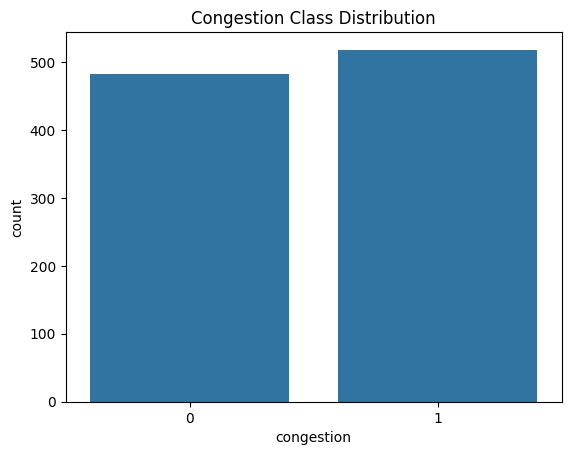

In [5]:
# Class Imbalance
sns.countplot(x='congestion', data=df)
plt.title('Congestion Class Distribution')
plt.show()

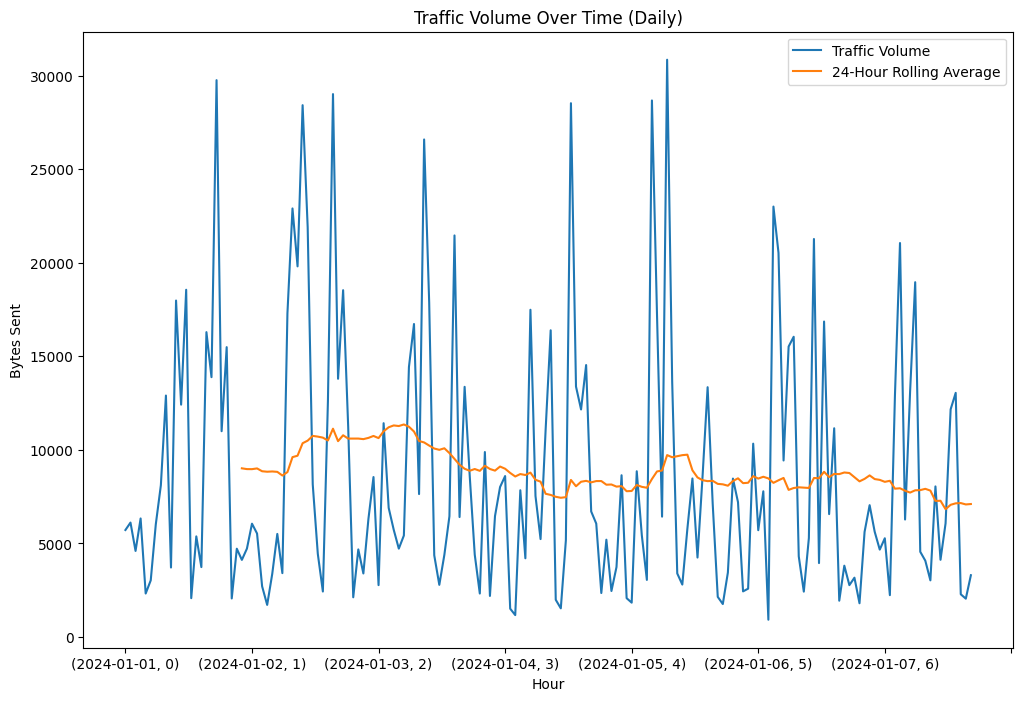

In [6]:
# Time Series Analysis (Traffic Volume - Improved)
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.date
traffic_volume = df.groupby(['day', 'hour'])['bytes_sent'].sum()

traffic_volume.plot(kind='line', figsize=(12, 8), label='Traffic Volume')
traffic_volume_rolling = traffic_volume.rolling(window=24).mean()  # 24-hour rolling average
traffic_volume_rolling.plot(kind='line', figsize=(12, 8), label='24-Hour Rolling Average')
plt.title('Traffic Volume Over Time (Daily)')
plt.xlabel('Hour')
plt.ylabel('Bytes Sent')
plt.legend()
plt.show()

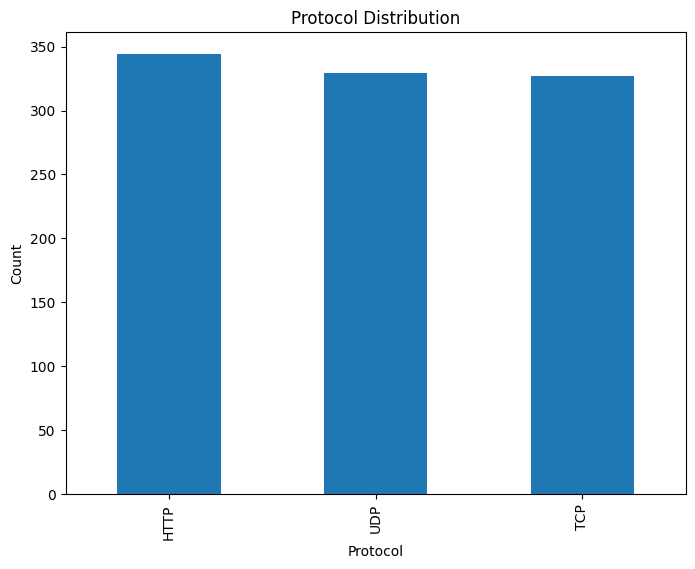

In [7]:
# Protocol Distribution
protocol_counts = df['protocol'].value_counts()
plt.figure(figsize=(8, 6))
protocol_counts.plot(kind='bar')
plt.title('Protocol Distribution')
plt.xlabel('Protocol')
plt.ylabel('Count')
plt.show()

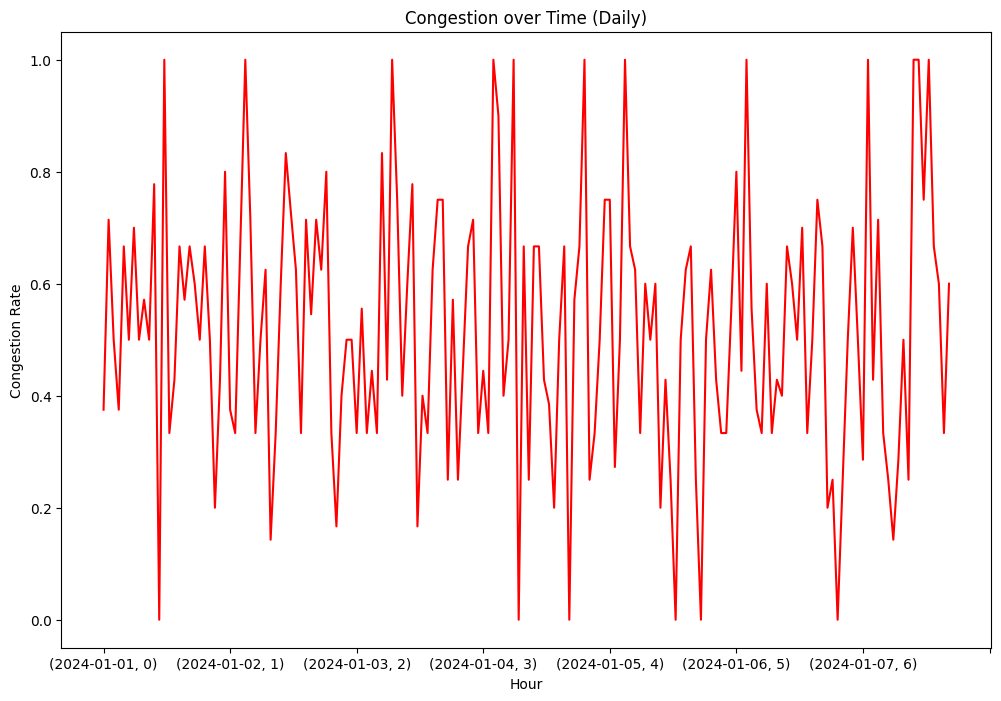

In [8]:
# Congestion Analysis over time
congestion_over_time = df.groupby(['day', 'hour'])['congestion'].mean()
congestion_over_time.plot(kind='line', figsize=(12, 8), color='red')
plt.title('Congestion over Time (Daily)')
plt.xlabel('Hour')
plt.ylabel('Congestion Rate')
plt.show()

# **Feature Engineering:**

Raw network traffic data is transformed into features suitable for machine learning. This includes converting IP addresses to numerical representations, calculating rolling statistics (mean, sum) of packet sizes and bytes sent, extracting time-based features (hour of day, day of week, weekend indicator), one-hot encoding categorical variables (protocol), and calculating packet rate.  These engineered features capture important temporal and traffic-related patterns that contribute to congestion.

In [9]:
# 3. Feature Engineering (Enhanced)
def ip_to_int(ip_address):
    try:
        return int(ipaddress.IPv4Address(ip_address))
    except ipaddress.AddressValueError:
        return 0

In [10]:
df['source_ip_int'] = df['source_ip'].apply(ip_to_int)
df['dest_ip_int'] = df['dest_ip'].apply(ip_to_int)

df['packet_size_mean'] = df.groupby(['source_ip_int', 'dest_ip_int'])['packet_size'].transform('mean')
df['bytes_sent_sum'] = df.groupby(['source_ip_int', 'dest_ip_int'])['bytes_sent'].transform('sum')

df['packet_rate'] = df.groupby(['source_ip_int', 'dest_ip_int'])['packet_size'].transform(lambda x: x.rolling(window=5).mean().shift(1) / df['timestamp'].dt.second) #5 seconds window
df['packet_rate'] = df['packet_rate'].fillna(0) #Fill NaN values

df['day_of_week'] = df['timestamp'].dt.dayofweek  # 0=Monday, 6=Sunday
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

In [11]:
df = pd.get_dummies(df, columns=['protocol'])  # One-Hot Encoding

In [12]:
df = df.drop(['source_ip', 'dest_ip', 'day'], axis=1) # Drop all IP columns
df['timestamp_seconds'] = df['timestamp'].astype(np.int64) // 10**9
df = df.drop('timestamp', axis=1)

# **Feature Scaling:**

Numerical features are standardized using StandardScaler to have zero mean and unit variance. This prevents features with larger values from dominating the model and improves the performance of many machine learning algorithms.

In [13]:
# Feature Scaling
numerical_features = ['packet_size', 'bytes_sent', 'packet_size_mean', 'bytes_sent_sum', 'timestamp_seconds', 'hour', 'source_ip_int', 'dest_ip_int', 'packet_rate']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# **Model Training and Evaluation:**

A Random Forest classifier is trained to predict network congestion. Time series cross-validation is employed to ensure robust model evaluation on time-dependent data, preventing data leakage.  Hyperparameter tuning is performed using RandomizedSearchCV to optimize the model's performance. The model is evaluated using a comprehensive set of metrics, including classification report, confusion matrix, precision, recall, and AUC-ROC. Feature importances are analyzed to understand which features are most influential in predicting congestion.

In [14]:
# Model Training and Evaluation (Improved)
X = df.drop('congestion', axis=1)
y = df['congestion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X.to_pickle('X.pkl')  # Save X to a pickle file

In [15]:
# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)
best_f1 = 0
best_model = None

for train_index, test_index in tscv.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    param_grid = {  # Expanded parameter grid
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 4] # Added min_samples_leaf
    }

    model = RandomForestClassifier(random_state=42)
    grid_search = RandomizedSearchCV(model, param_grid, cv=3, scoring='f1', n_iter=10) # Randomized search
    grid_search.fit(X_train_fold, y_train_fold)

    current_model = grid_search.best_estimator_
    y_pred_fold = current_model.predict(X_test_fold)
    f1 = f1_score(y_test_fold, y_pred_fold)
    if f1 > best_f1:
        best_f1 = f1
        best_model = current_model

y_pred = best_model.predict(X_test)

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91        97
           1       0.93      0.90      0.92       103

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.91       200
weighted avg       0.92      0.92      0.92       200



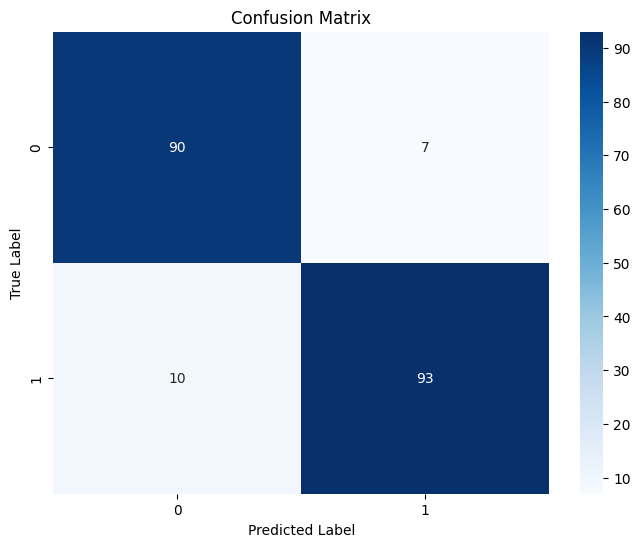

In [17]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [18]:
# Additional Metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC-ROC: {auc_roc}")

Precision: 0.93
Recall: 0.9029126213592233
AUC-ROC: 0.9153738364528076


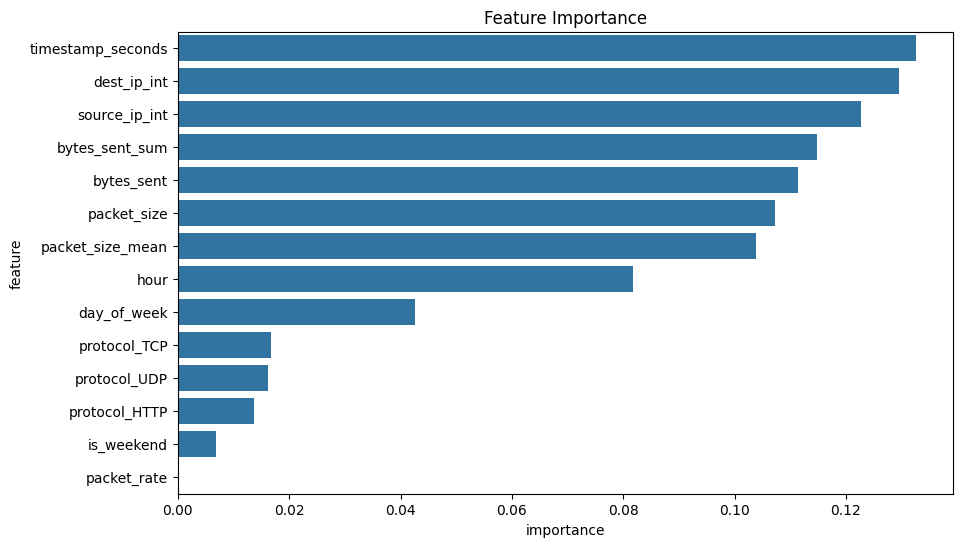

              feature  importance
13  timestamp_seconds    0.132553
4         dest_ip_int    0.129530
3       source_ip_int    0.122747
6      bytes_sent_sum    0.114783
1          bytes_sent    0.111391
0         packet_size    0.107281
5    packet_size_mean    0.103892
2                hour    0.081744
8         day_of_week    0.042643
11       protocol_TCP    0.016782
12       protocol_UDP    0.016130
10      protocol_HTTP    0.013602
9          is_weekend    0.006920
7         packet_rate    0.000000


In [19]:
feature_importances = best_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

print(importance_df)

# **Model Saving:**

The trained Random Forest model and the fitted StandardScaler are saved using pickle. This allows for easy deployment of the model without requiring retraining.  The saved model can be loaded and used for real-time congestion prediction. The X dataframe is also saved as it is required in the prediction part to ensure the same columns and order as the training data.

In [20]:
# Save the Model and Scaler (same as before)
import pickle
with open('congestion_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# **Congestion Prediction Function (Inference):**

A function is defined to take new network traffic data as input, perform the same feature engineering and scaling steps as during training, load the saved model, and return a congestion prediction.  This function encapsulates the prediction process, making it easy to use for new data.

In [21]:
def predict_congestion(input_data):
    """
    Predicts traffic congestion using the saved model.

    Args:
        input_data (dict): A dictionary containing the input features for prediction.
                           Keys should match the feature names used during training.
                           Example:
                           {
                               'packet_size': 1000,
                               'bytes_sent': 4000,
                               'hour': 17,
                               'source_ip': '192.168.1.10',
                               'dest_ip': '10.0.0.20',
                               'protocol': 'TCP',
                               'timestamp_seconds': 1700000000  # Example timestamp in seconds
                           }

    Returns:
        int: The predicted congestion level (0 or 1).
        or
        str: An error message if input is invalid.
    """

    try:
        # 1. Input Validation and Preprocessing
        input_df = pd.DataFrame([input_data])  # Create a DataFrame

        # IP Conversion
        input_df['source_ip_int'] = input_df['source_ip'].apply(ip_to_int)
        input_df['dest_ip_int'] = input_df['dest_ip'].apply(ip_to_int)

        # Feature Engineering (mimic training process)
        input_df['packet_size_mean'] = input_df.groupby(['source_ip_int', 'dest_ip_int'])['packet_size'].transform('mean') #This line might create issues if it is a new pair of source and destination IP.
        input_df['bytes_sent_sum'] = input_df.groupby(['source_ip_int', 'dest_ip_int'])['bytes_sent'].transform('sum') #This line might create issues if it is a new pair of source and destination IP.
        input_df['packet_rate'] = 0 #We can't calculate packet rate for a single input, so setting zero. It is important to remove from features if it does not have high importance.
        input_df['day_of_week'] = pd.to_datetime(input_df['timestamp_seconds'], unit='s').dt.dayofweek
        input_df['is_weekend'] = (input_df['day_of_week'] >= 5).astype(int)
        input_df = pd.get_dummies(input_df, columns=['protocol'])

        # Drop original IP strings
        input_df = input_df.drop(['source_ip', 'dest_ip'], axis=1)

        # Handle potential missing columns after one-hot encoding
        missing_cols = set(X.columns) - set(input_df.columns)
        for c in missing_cols:
            input_df[c] = 0
        # Ensure correct column order
        input_df = input_df[X.columns]

        # 2. Feature Scaling
        input_df[numerical_features] = scaler.transform(input_df[numerical_features])

        # 3. Model Loading and Prediction
        with open('congestion_model.pkl', 'rb') as f:
            model = pickle.load(f)

        prediction = model.predict(input_df)[0]
        return prediction

    except (ValueError, KeyError, TypeError) as e:
        return f"Invalid input data: {e}"
    except FileNotFoundError:
        return "Model or scaler file not found."
    except Exception as e:
        return f"An unexpected error occurred: {e}"

# Load the scaler and features used for training outside the function (only once)
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('congestion_model.pkl', 'rb') as f:
    model = pickle.load(f)
X = pd.read_pickle('X.pkl')
numerical_features = ['packet_size', 'bytes_sent', 'packet_size_mean', 'bytes_sent_sum', 'timestamp_seconds', 'hour', 'source_ip_int', 'dest_ip_int', 'packet_rate']

# Example usage:
input_data = {
    'packet_size': 1200,
    'bytes_sent': 4800,
    'hour': 17,
    'source_ip': '192.168.1.10',
    'dest_ip': '10.0.0.20',
    'protocol': 'TCP',
    'timestamp_seconds': 1700000000,
}

prediction = predict_congestion(input_data)
print(f"Predicted Congestion: {prediction}")

input_data_2 = {
    'packet_size': 1000,
    'bytes_sent': 9000,
    'hour': 17,
    'source_ip': '192.168.1.0',
    'dest_ip': '10.0.0.0',
    'protocol': 'TCP',
    'timestamp_seconds': 1700000001,
}

prediction_2 = predict_congestion(input_data_2)
print(f"Predicted Congestion for another input: {prediction_2}")

Predicted Congestion: 1
Predicted Congestion for another input: 0
